#4 Preprocessing

## 4.1 Data Source

### 4.1.1 Importing Packages

In [1]:
# importing packages
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# time series
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# genrate random number
import random

# model metrics
from sklearn.metrics import mean_squared_error

# normalize data
from sklearn.preprocessing import MinMaxScaler

# RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [2]:
def plot_forecast(funct,data,title):
  fig,ax=plt.subplots()
  funct.plot(ax=ax)
  data.plot(ax=ax,color='red')
  plt.title(title)
  plt.legend(labels=['predicted values','actual_values'])
  plt.show()

# importing collections
from collections import deque

### 4.1.2 Importing Data

In [3]:
sales_features=pd.read_csv('/content/drive/MyDrive/machine_learning_projects/retail_sales_prediction/data/sales_features_cleaned.csv')

In [4]:
sales_features.shape

(421570, 20)

In [5]:
sales_features.head()

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,median_weekly_sales,Type,Size,num_dept,sales_type
0,0,1,1,2010-05-02,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,10289.375,A,151315,77,positive_sales
1,1,1,1,2010-12-02,46039.49,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,10289.375,A,151315,77,positive_sales
2,2,1,1,2010-02-19,41595.55,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,10289.375,A,151315,77,positive_sales
3,3,1,1,2010-02-26,19403.54,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,10289.375,A,151315,77,positive_sales
4,4,1,1,2010-05-03,21827.90,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,10289.375,A,151315,77,positive_sales


### 4.1.3 Functions

In [6]:
def outlier_detect(df,var):
  qtr1=df[var].quantile(.25).values
  qtr

### 4.1.4 Data Formatting

In [7]:
sales_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           421570 non-null  int64  
 1   Store                421570 non-null  int64  
 2   Dept                 421570 non-null  int64  
 3   Date                 421570 non-null  object 
 4   Weekly_Sales         421570 non-null  float64
 5   Temperature          421570 non-null  float64
 6   Fuel_Price           421570 non-null  float64
 7   MarkDown1            150681 non-null  float64
 8   MarkDown2            111248 non-null  float64
 9   MarkDown3            137091 non-null  float64
 10  MarkDown4            134967 non-null  float64
 11  MarkDown5            151432 non-null  float64
 12  CPI                  421570 non-null  float64
 13  Unemployment         421570 non-null  float64
 14  IsHoliday            421570 non-null  bool   
 15  median_weekly_sal

In [8]:
# drop Unnamed: 0
sales_features.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
# store and dept as strings
sales_features['Store']=sales_features.Store.astype(str)
sales_features['Dept']=sales_features.Dept.astype(str)

sales_features['Date']=pd.to_datetime(sales_features['Date'])

In [10]:
sales_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                421570 non-null  object        
 1   Dept                 421570 non-null  object        
 2   Date                 421570 non-null  datetime64[ns]
 3   Weekly_Sales         421570 non-null  float64       
 4   Temperature          421570 non-null  float64       
 5   Fuel_Price           421570 non-null  float64       
 6   MarkDown1            150681 non-null  float64       
 7   MarkDown2            111248 non-null  float64       
 8   MarkDown3            137091 non-null  float64       
 9   MarkDown4            134967 non-null  float64       
 10  MarkDown5            151432 non-null  float64       
 11  CPI                  421570 non-null  float64       
 12  Unemployment         421570 non-null  float64       
 13  IsHoliday     

## 4.2 Collect Store Level Data

### 4.2.1 Aggregating Store Weekly Sales

Since the negative sales data is likely a data issue, I will replace all negative sales value with zero before aggregating the department sales for each store.

In [11]:
# replace negative weekly sales values with 0
non_neg_sales=[0 if row <0 else row for row in sales_features.Weekly_Sales]

In [12]:
# replaces the column
sales_features['Weekly_Sales']=non_neg_sales

# checking results
sales_features.Weekly_Sales.describe()

count    421570.000000
mean      15981.467250
std       22711.032446
min           0.000000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [13]:
del non_neg_sales

In [14]:
# summing weekly sales accross all departments
store_weekly_sales=sales_features.pivot_table(index='Store', columns=['Date'], values=['Weekly_Sales'], aggfunc='sum')

# transpose the matrix to remove the column tuple names
store=store_weekly_sales.T

# reset the index
store.reset_index(inplace=True)

store

Store,level_0,Date,1,10,11,12,13,14,15,16,...,41,42,43,44,45,5,6,7,8,9
0,Weekly_Sales,2010-01-10,1453329.50,1645892.97,1182593.46,850936.26,1765595.56,1855703.66,566959.75,463977.54,...,1109216.35,481523.93,657108.77,300152.45,690007.76,283178.12,1328468.89,448998.73,804105.49,495692.19
1,Weekly_Sales,2010-02-04,1594968.28,2138651.97,1446210.26,1011822.30,2142482.14,2495630.51,718470.71,490503.69,...,1168826.39,505907.41,650102.80,286210.50,877235.96,331406.00,1770333.90,561145.14,914500.91,545206.32
2,Weekly_Sales,2010-02-07,1492418.14,1845906.47,1302600.14,951957.31,2018314.71,2334788.42,709337.11,610641.42,...,1273279.79,507168.80,667353.79,300628.19,800148.11,305993.27,1759777.25,575570.77,852333.75,528833.54
3,Weekly_Sales,2010-02-19,1612831.17,2113432.58,1503298.70,1095433.65,1970274.64,2204556.70,660838.75,469868.70,...,1052034.74,508794.87,658997.55,267956.30,841264.31,303447.57,1567138.07,506760.54,963960.37,511327.90
4,Weekly_Sales,2010-02-26,1409727.59,2006787.70,1336404.65,1048617.17,1817850.32,2095591.63,564923.20,443242.17,...,991942.73,491510.58,618702.79,273079.07,743641.65,270281.63,1432953.21,496083.24,847592.11,473773.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,Weekly_Sales,2012-10-08,1592549.62,1880436.94,1388976.65,984689.90,2041117.92,1648570.03,590453.63,554036.84,...,1504545.94,576620.31,643558.78,333597.31,733037.32,306759.70,1588380.73,675926.30,930745.69,538713.47
139,Weekly_Sales,2012-10-19,1508068.77,1734834.82,1232073.18,960968.35,2018010.15,1590274.72,555652.77,577198.97,...,1326197.24,541406.98,623919.23,323766.77,718125.53,313358.15,1436883.99,516424.83,900309.75,542009.46
140,Weekly_Sales,2012-10-26,1493659.74,1744349.05,1200729.45,974697.60,2035189.66,1704357.62,558473.60,475770.14,...,1316542.59,514758.55,587603.55,361067.07,760281.43,319550.77,1431447.97,495543.28,891671.44,549731.49
141,Weekly_Sales,2012-11-05,1611096.05,1792345.30,1300147.07,1042543.22,2080765.94,1987531.05,579539.95,479855.00,...,1353285.10,643683.67,640159.04,341381.08,770487.37,333870.52,1517075.67,460397.41,920128.89,592572.30


In [15]:
del store_weekly_sales, sales_features

In [16]:
# drop level 0 column
store.drop(columns=['level_0'], inplace=True)
store

Store,Date,1,10,11,12,13,14,15,16,17,...,41,42,43,44,45,5,6,7,8,9
0,2010-01-10,1453329.50,1645892.97,1182593.46,850936.26,1765595.56,1855703.66,566959.75,463977.54,829207.27,...,1109216.35,481523.93,657108.77,300152.45,690007.76,283178.12,1328468.89,448998.73,804105.49,495692.19
1,2010-02-04,1594968.28,2138651.97,1446210.26,1011822.30,2142482.14,2495630.51,718470.71,490503.69,848551.17,...,1168826.39,505907.41,650102.80,286210.50,877235.96,331406.00,1770333.90,561145.14,914500.91,545206.32
2,2010-02-07,1492418.14,1845906.47,1302600.14,951957.31,2018314.71,2334788.42,709337.11,610641.42,958885.37,...,1273279.79,507168.80,667353.79,300628.19,800148.11,305993.27,1759777.25,575570.77,852333.75,528833.54
3,2010-02-19,1612831.17,2113432.58,1503298.70,1095433.65,1970274.64,2204556.70,660838.75,469868.70,800731.74,...,1052034.74,508794.87,658997.55,267956.30,841264.31,303447.57,1567138.07,506760.54,963960.37,511327.90
4,2010-02-26,1409727.59,2006787.70,1336404.65,1048617.17,1817850.32,2095591.63,564923.20,443242.17,749549.55,...,991942.73,491510.58,618702.79,273079.07,743641.65,270281.63,1432953.21,496083.24,847592.11,473773.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2012-10-08,1592549.62,1880436.94,1388976.65,984689.90,2041117.92,1648570.03,590453.63,554036.84,849075.54,...,1504545.94,576620.31,643558.78,333597.31,733037.32,306759.70,1588380.73,675926.30,930745.69,538713.47
139,2012-10-19,1508068.77,1734834.82,1232073.18,960968.35,2018010.15,1590274.72,555652.77,577198.97,957356.84,...,1326197.24,541406.98,623919.23,323766.77,718125.53,313358.15,1436883.99,516424.83,900309.75,542009.46
140,2012-10-26,1493659.74,1744349.05,1200729.45,974697.60,2035189.66,1704357.62,558473.60,475770.14,943476.29,...,1316542.59,514758.55,587603.55,361067.07,760281.43,319550.77,1431447.97,495543.28,891671.44,549731.49
141,2012-11-05,1611096.05,1792345.30,1300147.07,1042543.22,2080765.94,1987531.05,579539.95,479855.00,944100.30,...,1353285.10,643683.67,640159.04,341381.08,770487.37,333870.52,1517075.67,460397.41,920128.89,592572.30


In [17]:
# convert back to long format
store2=store.melt(id_vars='Date', var_name='Store',value_name='weekly_sales')
store2

,Date,Store,weekly_sales
0,2010-01-10,1,1453329.50
1,2010-02-04,1,1594968.28
2,2010-02-07,1,1492418.14
3,2010-02-19,1,1612831.17
4,2010-02-26,1,1409727.59
...,...,...,...
6430,2012-10-08,9,538713.47
6431,2012-10-19,9,542009.46
6432,2012-10-26,9,549731.49
6433,2012-11-05,9,592572.30


In [18]:
del store

### 4.2.2 Checking for Missing Values

In [19]:
store2.isna().sum()

Date            0
Store           0
weekly_sales    0
dtype: int64

## 4.3 Checking Integrety of Sales

In [20]:
store2.describe()

,weekly_sales
count,6.435000e+03
mean,1.046979e+06
std,5.643705e+05
min,2.099862e+05
25%,5.533501e+05
50%,9.607460e+05
75%,1.420159e+06
max,3.818686e+06


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


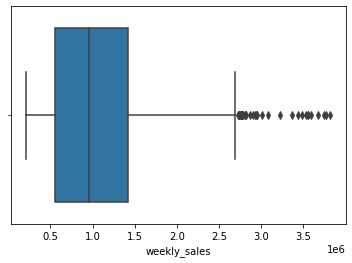

In [21]:
sns.boxplot(store2.weekly_sales)
plt.show()

In [22]:
qtr1=store2.quantile(.25).values
qtr3=store2.quantile(.75).values
iqr=qtr3 - qtr1

store2['outlier']=['outlier' if row >iqr else 'non_outlier' for row in store2.weekly_sales]

store2

,Date,Store,weekly_sales,outlier
0,2010-01-10,1,1453329.50,outlier
1,2010-02-04,1,1594968.28,outlier
2,2010-02-07,1,1492418.14,outlier
3,2010-02-19,1,1612831.17,outlier
4,2010-02-26,1,1409727.59,outlier
...,...,...,...,...
6430,2012-10-08,9,538713.47,non_outlier
6431,2012-10-19,9,542009.46,non_outlier
6432,2012-10-26,9,549731.49,non_outlier
6433,2012-11-05,9,592572.30,non_outlier


In [23]:
del iqr, qtr1, qtr3

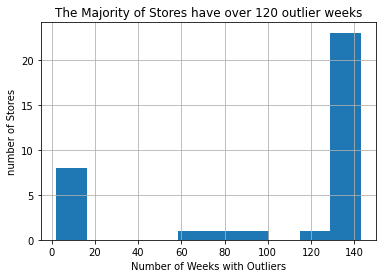

In [24]:
store_outlier=store2[store2.outlier=='outlier'].groupby('Store')['outlier'].count()

pd.DataFrame(store_outlier.values, index=store_outlier.index, columns=['num_of_weeks_outliers']).sort_values('num_of_weeks_outliers', ascending=False).hist()
plt.xlabel('Number of Weeks with Outliers')
plt.ylabel('number of Stores')
plt.title('The Majority of Stores have over 120 outlier weeks')
plt.show()


In [25]:
del store_outlier

There were 143 weeks of sales dates, so those stores with 143 weeks of potential outliers are just stores that have high sales. Since the majority stores seems to fall in this category, aggregating sales does not provide any use information. Thus, it makes sense to focus on each store individually.

## 4.4 Train Test split

### 4.4.1 Setting Stores as columns

In [26]:
# set index to Date
store2.index=store2.Date

In [27]:
#drop Date column
store2.drop(columns=['Date'],inplace=True)

store2.head()

,Store,weekly_sales,outlier
Date,,,
2010-01-10,1,1453329.50,outlier
2010-02-04,1,1594968.28,outlier
2010-02-07,1,1492418.14,outlier
2010-02-19,1,1612831.17,outlier
2010-02-26,1,1409727.59,outlier


In [28]:
store_sales=store2.pivot_table(index='Date', columns=['Store'], values=['weekly_sales'])

store_sales.head()

weekly_sales                                                  \
Store                 1          10          11          12          13   
Date                                                                      
2010-01-10   1453329.50  1645892.97  1182593.46   850936.26  1765595.56   
2010-02-04   1594968.28  2138651.97  1446210.26  1011822.30  2142482.14   
2010-02-07   1492418.14  1845906.47  1302600.14   951957.31  2018314.71   
2010-02-19   1612831.17  2113432.58  1503298.70  1095433.65  1970274.64   
2010-02-26   1409727.59  2006787.70  1336404.65  1048617.17  1817850.32   

                                                                     ...  \
Store               14         15         16         17          18  ...   
Date                                                                 ...   
2010-01-10  1855703.66  566959.75  463977.54  829207.27   948994.50  ...   
2010-02-04  2495630.51  718470.71  490503.69  848551.17  1254107.84  ...   
2010-02-07  2334788.42  709337.11  610641.42  958885.37  1257929.91  ...   
2010-02-19  2204556.70  660838.75  469868.70  800731.74  1150663.42  ...   
2010-02-26  2095591.63  564923.20  443242.17  749549.55  1068157.45  ...   

                                                                               \
Store               41         42         43         44         45          5   
Date                                                                            
2010-01-10  1109216.35  481523.93  657108.77  300152.45  690007.76  283178.12   
2010-02-04  1168826.39  505907.41  650102.80  286210.50  877235.96  331406.00   
2010-02-07  1273279.79  507168.80  667353.79  300628.19  800148.11  305993.27   
2010-02-19  1052034.74  508794.87  658997.55  267956.30  841264.31  303447.57   
2010-02-26   991942.73  491510.58  618702.79  273079.07  743641.65  270281.63   

                                                         
Store                6          7          8          9  
Date                                                     
2010-01-10  1328468.89  448998.73  804105.49  495692.19  
2010-02-04  1770333.90  561145.14  914500.91  545206.32  
2010-02-07  1759777.25  575570.77  852333.75  528833.54  
2010-02-19  1567138.07  506760.54  963960.37  511327.90  
2010-02-26  1432953.21  496083.24  847592.11  473773.27  

[5 rows x 45 columns]

In [29]:
del store2

### 4.4.2 Selecting Stores

Since I need to treat each store as a seperate time series, I will randomly select one store to model.

In [30]:
random.seed(42)

# create a list of numbers from 0 to 44
list1=list(np.arange(0,45))

# randomly select 5 elements
sample=random.sample(list1,1)

sample

[40]

In [31]:
# selcting 5 stores
store=store_sales.iloc[:,sample]

# checking results
store.head()

,weekly_sales
Store,5
Date,
2010-01-10,283178.12
2010-02-04,331406.00
2010-02-07,305993.27
2010-02-19,303447.57
2010-02-26,270281.63


In [32]:
del store_sales, list1, sample

### 4.4.3 training and test set

In [33]:
# begining and ending dates
store.index[0],store.index[-7]

(Timestamp('2010-01-10 00:00:00'), Timestamp('2012-09-28 00:00:00'))

In [34]:
# collect the first 75% observation for the training set
train=store.iloc[:int(.75*store.shape[0]),:]

train.head()

,weekly_sales
Store,5
Date,
2010-01-10,283178.12
2010-02-04,331406.00
2010-02-07,305993.27
2010-02-19,303447.57
2010-02-26,270281.63


In [35]:
train.shape

(107, 1)

In [36]:
# using remaining 25% as test set
test=store.iloc[int(.75*store.shape[0]):,:]

test.head()

,weekly_sales
Store,5
Date,
2012-03-02,333948.00
2012-03-08,324205.85
2012-03-16,339392.54
2012-03-23,321299.99
2012-03-30,331318.73


In [37]:
test.shape

(36, 1)

In [38]:
del store

### 4.4.4 Seperating into Stores

In [39]:
# creating store 5 train and test set
store5_train=train.loc[:,('weekly_sales',  '5')]
store5_test=test.loc[:,('weekly_sales',  '5')]

store5_train

Date
2010-01-10    283178.12
2010-02-04    331406.00
2010-02-07    305993.27
2010-02-19    303447.57
2010-02-26    270281.63
                ...    
2012-01-20    287523.98
2012-01-27    295974.22
2012-02-03    359206.21
2012-02-17    356427.98
2012-02-24    312220.47
Name: (weekly_sales, 5), Length: 107, dtype: float64

In [40]:
del train, test

# 5 Models

We will create a model for stores 5, 10, 16, 23, and 25

In [41]:
# creating a data frame for train and test sets
store5_train_df=pd.DataFrame(store5_train.values, index=store5_train.index, columns=['weekly_sales'])
store5_test_df=pd.DataFrame(store5_test.values, index=store5_test.index, columns=['weekly_sales'])

In [42]:
del store5_train, store5_test

## 5.1 Time Series Plot

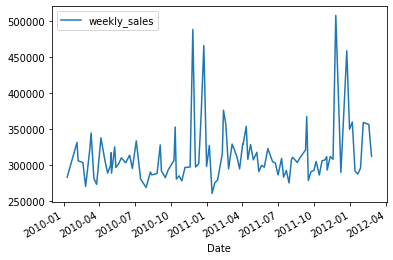

In [43]:
store5_train_df.plot()
plt.show()

There appears to be seasonality in the data and quite possibly a slight trend; thus, we will use seasonal decompose to highlight the seasonality and possible trend. Also, the slight trend near the end of the data may suggest a possible structural break.

## 5.2 Time Series Decomposition

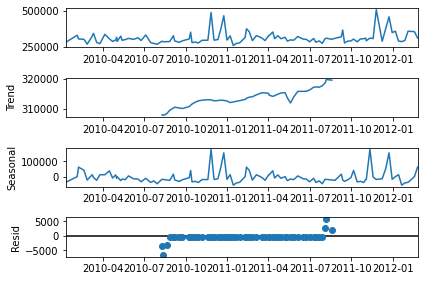

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose series
store5_decomp=seasonal_decompose(store5_train_df,'additive',period=52)

# plot components
store5_decomp.plot()
plt.show()

The decomposition of the time series shows a trend and seasonality.

## 5.3 Exponential Smoothing

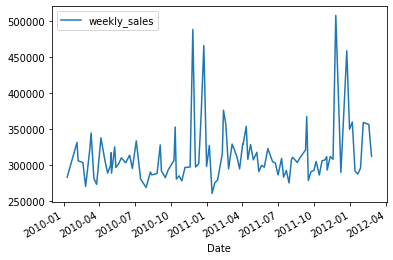

In [45]:
# time series plot
store5_train_df.plot()
plt.show()

In [46]:
# fitting simple exponential smoothing model
simple_exp=SimpleExpSmoothing(store5_train_df).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [47]:
store5_train_df.index[0], store5_train_df.index[-1]

(Timestamp('2010-01-10 00:00:00'), Timestamp('2012-02-24 00:00:00'))

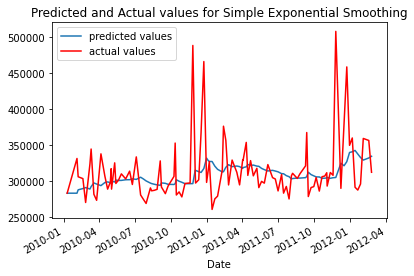

In [48]:
# plotting forecast and actual values
fig1,ax1=plt.subplots()
simple_exp.predict(start='2010-01-10 00:00:00',end='2012-02-24 00:00:00').plot(ax=ax1)
store5_train_df.plot(ax=ax1,color='red')
plt.legend(labels=['predicted values','actual values'])
plt.title('Predicted and Actual values for Simple Exponential Smoothing')
plt.show()

In [49]:
# root mean squared error
round(np.sqrt(mean_squared_error(store5_train_df.values, simple_exp.predict(start='2010-01-10 00:00:00',end='2012-02-24 00:00:00').values)),0)

41527.0

## 5.4 Double Exponential Smoothing

In [50]:
exp_smoothing=ExponentialSmoothing(store5_train_df,seasonal='additive',seasonal_periods=52,initialization_method='estimated').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


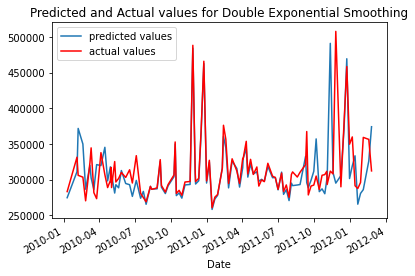

In [51]:
# plotting predicted values and actual values
fig2,ax2=plt.subplots()

exp_smoothing.predict(start='2010-01-10 00:00:00',end='2012-02-24 00:00:00').plot(ax=ax2)
store5_train_df.plot(ax=ax2,color='red')

plt.legend(labels=['predicted values','actual values'])
plt.title('Predicted and Actual values for Double Exponential Smoothing')
plt.show()

In [52]:
# rmse
round(np.sqrt(mean_squared_error(store5_train_df,exp_smoothing.predict(start='2010-01-10 00:00:00',end='2012-02-24 00:00:00'))),0)

34196.0

## 5.5 SARIMA

### 5.5.1 Determine Model Order

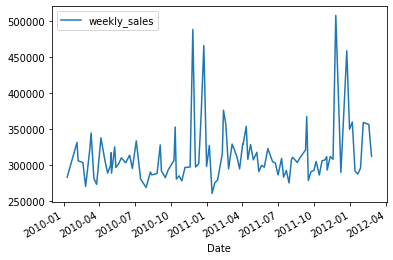

In [53]:
# time Series Plot
store5_train_df.plot()
plt.show()

#### 5.5.1.1 Stationarity

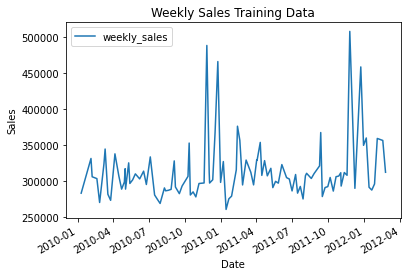

In [54]:
# time series plot
pd.DataFrame(store5_train_df).plot()
plt.title('Weekly Sales Training Data')
plt.ylabel('Sales')
plt.show()

In [55]:
adfuller(store5_train_df.weekly_sales.values)

(-8.831674191788526,
 1.7629406497978512e-14,
 0,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 2250.423927681801)

In [56]:
# collect the mean
store5_mean=store5_train_df.weekly_sales.rolling(52).mean

#### 5.5.1.2 Determine Seasonal Period

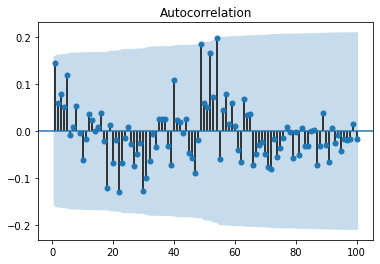

In [57]:
# plotting ACF
plot_acf(store5_train_df.weekly_sales,lags=100,zero=False,alpha=0.10,use_vlines=True)
plt.show()

#### 5.5.1.3 Determine Seasaonal AR and MA

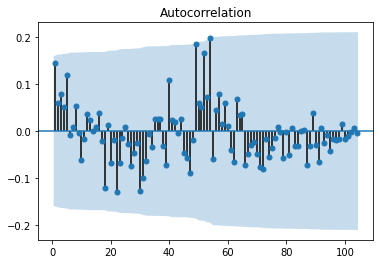

In [58]:
plot_acf(store5_train_df.weekly_sales,lags=104,alpha=0.1,zero=False)
plt.show()

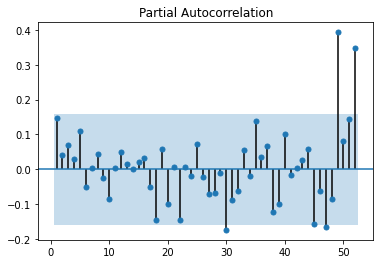

In [59]:
plot_pacf(store5_train_df.weekly_sales,lags=52,alpha=0.10,zero=False)
plt.show()

#### 5.5.1.4 Determine Non-seasonal Order

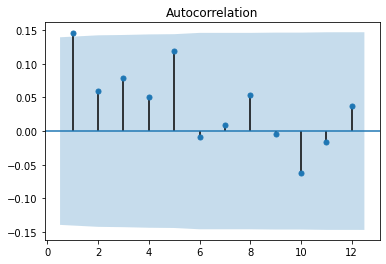

In [60]:
# plot acf
plot_acf(store5_train_df.weekly_sales,lags=12,zero=False,alpha=0.15)
plt.show()

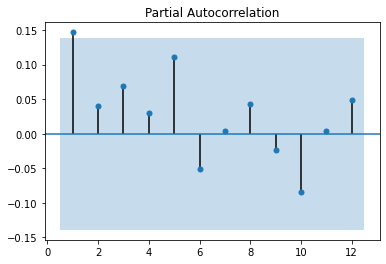

In [61]:
# plot pacf
plot_pacf(store5_train_df.weekly_sales,lags=12,zero=False,alpha=0.15)
plt.show()

In an effort to increase accuracy, I added non-seasonal term. Although the short lags for ACF and PACF are not statistically significant at 10% level, I set MA term to 1 for the next model.

#### 5.5.1.5 SARIMA Model Order Summary

With a p-value very close to zero, we reject the null hypothesis for the augmented dicky fuller test, and conclude there is enough evidence to suggest the data is stationary. ACF has a significant lag at 52, which suggest the seasonal period is 52. Since the data is weekly and there are 52 weeks in a year, it makes sense the period is 52. Additionally, there are no significant lags before 52, which suggests the is no autoregressive or moving average term for the non-seasonal part. To determine the seasonal order, we will need to plot lags of multiple of 52. Since PACF decays at multiple of 52 while ACF drops after 52, the seasonal part is MA(1). Thus, the seasonal ARIMA mode is (0,0,0)(0,0,1)52.

### 5.5.2 Fit SARIMA

#### 5.5.2.1 SARIMA (0,0,0) (0,0,1,52)

In [62]:
store5_sarimax=SARIMAX(store5_train_df.weekly_sales,order=(0,0,0),seasonal_order=(0,0,1,52),trend='c').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


In [63]:
store5_train_df.index[0],store5_train_df.index[-1]

(Timestamp('2010-01-10 00:00:00'), Timestamp('2012-02-24 00:00:00'))

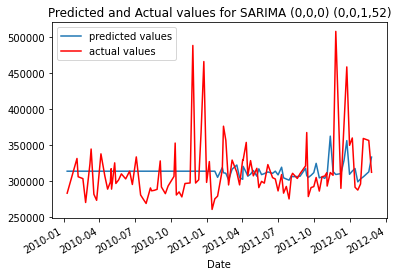

In [64]:
# plot predicted vs actual value for training set
fig,ax=plt.subplots(sharey=True)
store5_sarimax.predict(start='2010-01-10 00:00:00',end='2012-02-24 00:00:00').plot(ax=ax)
store5_train_df.plot(color='red',ax=ax)
plt.legend(labels=['predicted values','actual values'])
plt.title('Predicted and Actual values for SARIMA (0,0,0) (0,0,1,52)')
plt.show()

In [65]:
# mean squared error
round(np.sqrt(mean_squared_error(store5_train_df,store5_sarimax.predict(start='2010-01-10 00:00:00',end='2012-02-24 00:00:00'))),0)

40068.0

#### 5.5.2.2 SARIMA (1,0,1) (0,0,1,52)

In [ ]:
store5_sarimax2=SARIMAX(store5_train_df.weekly_sales,order=(0,0,1),seasonal_order=(0,0,1,52),trend='c').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


In [ ]:
# plot predicted vs actual value for training set
fig,ax=plt.subplots(sharey=True)
store5_sarimax2.predict(start='2010-01-10 00:00:00',end='2012-02-24 00:00:00').plot(ax=ax)
store5_train_df.plot(color='red',ax=ax)
plt.legend(labels=['predicted values','actual values'])
plt.title('Predicted and Actual values for SARIMA (0,0,1) (0,0,1,52)')
plt.show()

In [ ]:
# mean squared error
round(np.sqrt(mean_squared_error(store5_train_df,store5_sarimax2.predict(start='2010-01-10 00:00:00',end='2012-02-24 00:00:00'))),0)

## 5.6 RNN

We will use 6 months of sales data to predict the next 1 month of data. Since the data is weekly data, the sequence length is 24 while the predict period is 4. 

In [ ]:
seq_len=24

predict_len=4

In [ ]:
store5_train_df.sort_index(inplace=True)
store5_test_df.sort_index(inplace=True)

In [ ]:
# inspect the train data
store5_train_df

In [ ]:
# inspect the test set
store5_test_df

### 5.6.1 Normalize Data

In [ ]:
# initiate MinMaxScaler
scaler=MinMaxScaler()

scaler.fit(store5_train_df.values)

In [ ]:
# normalize training set

norm_train=scaler.transform(store5_train_df.values)

# checking min and max
np.min(norm_train), np.max(norm_train)

In [ ]:
# normalize test set

norm_test=scaler.transform(store5_test_df.values)

# checking min and max
np.min(norm_test), np.max(norm_test)

### 5.6.2 Target Variable

In [ ]:
# creating new data frame
train=pd.DataFrame(norm_train, columns=['norm_weekly_sales'])
train

In [ ]:
# we want to predict one month out, so we shift the data by 4 weeks
train['target']=train.shift(-predict_len)
train.dropna(inplace=True)

In [ ]:
test=pd.DataFrame(norm_test, columns=["norm_weekly_sales"])
test['target']=test.shift(-predict_len)
test.dropna(inplace=True)
test

### 5.6.3 Create Sequences

In [ ]:
def create_seq(df,seq_len):
  previous_weeks=deque(maxlen=seq_len)
  seq=[]

  for week in df.values:
    previous_weeks.append(week[0])
    if len(previous_weeks)== seq_len:
      seq.append([np.array(previous_weeks),week[1]])

  random.shuffle(seq)

  X=[]
  y=[]

  for item1, item2 in seq:
    X.append(item1)
    y.append(item2)
  return np.array(X), np.array(y).reshape(-1,1)


In [ ]:
X_train, y_train = create_seq(train, seq_len)

In [ ]:
# checking training results
y_train

In [ ]:
X_test, y_test=create_seq(test, seq_len)

# checking results
X_test, y_test

### 5.6.5 Model

In [ ]:
y_train.shape

In [ ]:
model = Sequential()

model.add(LSTM(50, input_shape=(24,1), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, input_shape=(24,1), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1))

model.compile(loss='mse', optimizer='adam')

In [ ]:
# fit the model
model.fit(X_train.reshape(80,24,1), y_train, batch_size=10, epochs=100, validation_data=(X_test, y_test))

print(model.summary())

Epoch 1/100
8/8 [==============================] - 8s 155ms/step - loss: 0.0531 - val_loss: 0.0212
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0401 - val_loss: 0.0049
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0371 - val_loss: 0.0057
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0370 - val_loss: 0.0041
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0381 - val_loss: 0.0085
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0342 - val_loss: 0.0040
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0352 - val_loss: 0.0037
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0345 - val_loss: 0.0042
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0335 - val_loss: 0.0053
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0339 - val_loss: 0.0041
Epoch 11/100
8/8 [====

In [ ]:
predict=model.predict(X_train.reshape(80,24,1))
predict


3/3 [==============================] - 1s 6ms/step


array([[0.22919257],
       [0.24486148],
       [0.26684627],
       [0.23261897],
       [0.2388156 ],
       [0.18148929],
       [0.24901968],
       [0.18382032],
       [0.19063234],
       [0.17003247],
       [0.2560503 ],
       [0.26192388],
       [0.20118257],
       [0.18390363],
       [0.19619748],
       [0.22109914],
       [0.26713833],
       [0.20170784],
       [0.26262438],
       [0.24020365],
       [0.25393185],
       [0.16575511],
       [0.26583463],
       [0.26010093],
       [0.26905945],
       [0.27003616],
       [0.1923325 ],
       [0.23745534],
       [0.21947801],
       [0.20819195],
       [0.23142599],
       [0.25593653],
       [0.25513113],
       [0.24968843],
       [0.2640837 ],
       [0.21260743],
       [0.26974654],
       [0.16170862],
       [0.2671387 ],
       [0.2305509 ],
       [0.2389391 ],
       [0.1946054 ],
       [0.26348886],
       [0.23537754],
       [0.1869001 ],
       [0.2704159 ],
       [0.25613186],
       [0.199

In [ ]:
round(np.sqrt(mean_squared_error(scaler.inverse_transform(y_train),scaler.inverse_transform(predict))),0)

44353.0

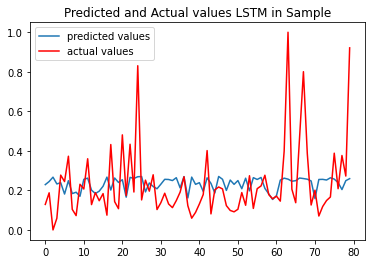

In [ ]:
fig,ax = plt.subplots()

pd.DataFrame(predict).plot(ax=ax)
pd.DataFrame(y_train).plot(ax=ax, color='red')
plt.legend(labels=['predicted values', 'actual values'])
plt.title('Predicted and Actual values LSTM in Sample')
plt.show()

## 5.7 Out of Sample Forecasts

### 5.6.1 Simple Exponential Model

In [ ]:
store5_test_df.index[0], store5_test_df.index[-1]

(Timestamp('2012-03-02 00:00:00'), Timestamp('2012-12-10 00:00:00'))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


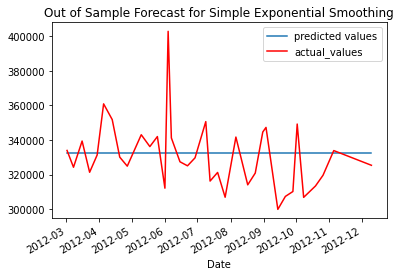

In [ ]:
# plot of predicted and actual values for out of sample 
plot_forecast(pd.DataFrame(simple_exp.forecast(36).values,index=store5_test_df.index),store5_test_df,'Out of Sample Forecast for Simple Exponential Smoothing')

In [ ]:
# out of sample RMSE
round(np.sqrt(mean_squared_error(store5_test_df,simple_exp.forecast(36))),0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


19205.0

### 5.6.2 Double Exponential Model

In [ ]:
# getting start and end date for test set
store5_test_df.index[0], store5_test_df.index[-1]

(Timestamp('2012-03-02 00:00:00'), Timestamp('2012-12-10 00:00:00'))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


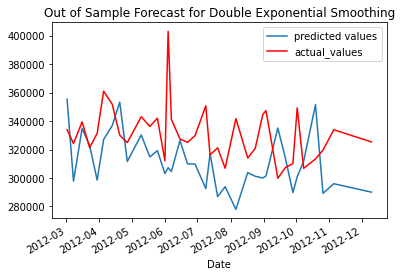

In [ ]:
# plotting out of sample predicted and actual values
plot_forecast(pd.DataFrame(exp_smoothing.forecast(36).values,index=store5_test_df.index),store5_test_df,'Out of Sample Forecast for Double Exponential Smoothing')

In [ ]:
# out of sample rmse
round(np.sqrt(mean_squared_error(store5_test_df,exp_smoothing.forecast(36))),0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


32994.0

### 5.6.3 SARIMA (0,0,0)(0,0,1,52)

In [ ]:
# test set start and stop values
store5_test_df.index[0], store5_test_df.index[-1]

(Timestamp('2012-03-02 00:00:00'), Timestamp('2012-12-10 00:00:00'))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


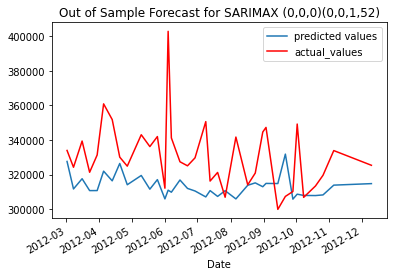

In [ ]:
# plotting out of sample predicted and actual values
plot_forecast(pd.DataFrame(store5_sarimax.forecast(36).values,index=store5_test_df.index),store5_test_df,'Out of Sample Forecast for SARIMAX (0,0,0)(0,0,1,52)')

In [ ]:
# out of sample rmse
round(np.sqrt(mean_squared_error(store5_test_df,store5_sarimax.forecast(36))),0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


26227.0

### 5.6.4 SARIMA (0,0,1)(0,0,1,52)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


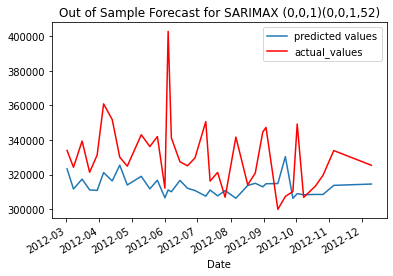

In [ ]:
# plotting out of sample predicted and actual values
plot_forecast(pd.DataFrame(store5_sarimax2.forecast(36).values,index=store5_test_df.index),store5_test_df,'Out of Sample Forecast for SARIMAX (0,0,1)(0,0,1,52)')

In [ ]:
# out of sample rmse
round(np.sqrt(mean_squared_error(store5_test_df,store5_sarimax2.forecast(36))),0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


26212.0

### 5.6.5 RNN

In [ ]:
oos_predict=model.predict(X_test.reshape(9,24,1))

round(np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(oos_predict))),0)

1/1 [==============================] - 0s 20ms/step


19174.0

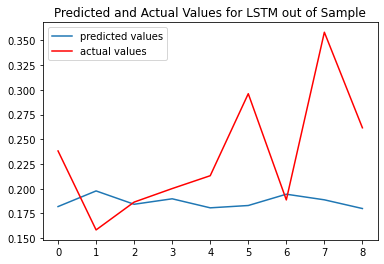

In [ ]:
fig,ax=plt.subplots()

pd.DataFrame(oos_predict).plot(ax=ax)
pd.DataFrame(y_test).plot(ax=ax, color='red')
plt.legend(labels=['predicted values', 'actual values'])
plt.title('Predicted and Actual Values for LSTM out of Sample')
plt.show()

## 5.8 Model Summary

In [ ]:
store5=pd.concat([store5_train_df,store5_test_df])

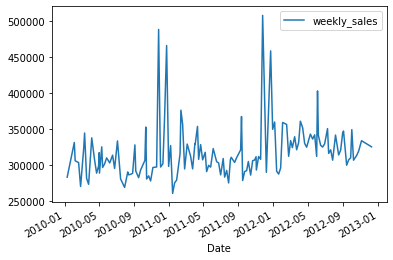

In [ ]:
store5.plot()
plt.show()

In [ ]:
store5.describe()

,weekly_sales
count,143.000000
mean,318014.823147
std,37737.946575
min,260636.710000
25%,294696.000000
50%,310338.170000
75%,329863.560000
max,507900.070000


It is interesting that for all four models the in-sample root mean squared error is larger than the out of sample. This suggests that the models did not overfit on the training data. Furthermore, it is interesting that the models switch ranks between in sample and of sample. The models with the highest (worst) error in sample have the lowest (best) error in out of sample. The same can be said the for the 2nd worst in sample as the 2nd best out of sample and so on. 

Since we are interested in predicting sales data, we will determine the best model by using the out of sample root mean squared error. Thus, LSTM, simple exponential smoothing, SARIMAX2, SARIMAX1, and double exponential smoothing have rmse of 15,066; 19,205; 26,212; 26,227; and 32,994, respectively. Since the median sales data for store 5 is 310,338, predictions being off of 15,000 means the predictions are fairly accurate. 

For future work, we would like to include additional variables into our SARIMAX and LSTM models. Additionally, we can look at structural breaks when testing for stationarity as well as modeling other stores. Sinc choosing the model order from the ACF and PACF is subjective, we would like to utilize auto ARIMA functions to determine the model order, and see it improves model performance.
